# TAPE Deconvolution

In [40]:
from benchmark_utils import (
    preprocess_scrna,
    create_uniform_pseudobulk_dataset,
    create_signature,
    add_cell_types_grouped,
)

from TAPE import Deconvolution
from TAPE.deconvolution import ScadenDeconvolution

import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc

from constants import (
    SIGNATURE_CHOICE,
    BENCHMARK_CELL_TYPE_GROUP,
    N_CELLS,
)

Load and preprocess scRNAseq data.

In [28]:
adata = sc.read("/home/owkin/project/cti/cti_adata.h5ad")
preprocess_scrna(adata,
                  keep_genes=3000,
                  log=False,
                  batch_key="donor_id")

adata

AnnData object with n_obs × n_vars = 329762 × 3000
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'sex_ontology_term_id_colors', 'title', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'relative_co

Create signature matrix & split dataset 

In [58]:
signature, intersection = create_signature(
    adata,
    signature_type=SIGNATURE_CHOICE,
)

signature

,CD4T,CD8T,B,Plasma,DC,NK,Mono,Mast,Tregs
Genes,,,,,,,,,
ENSG00000100300,0.692914,0.402336,0.316685,1.236341,2.597256,0.700936,8.236938,1.285106,0.791502
ENSG00000105374,0.140874,5.768637,0.022541,0.102757,0.701372,20.21416,0.539641,0.094833,0.045784
ENSG00000160593,0.169656,0.273075,0.003437,0.014536,3.140436,0.036484,0.979562,0.009119,0.155303
ENSG00000167995,0.066881,0.058113,0.08802,0.030576,0.33414,0.055134,0.305752,0.071125,0.061924
ENSG00000137198,0.003263,0.002838,0.003526,0.032331,0.064568,0.009969,0.025383,0.377508,0.001482
...,...,...,...,...,...,...,...,...,...
ENSG00000196975,0.040529,0.086394,0.075254,0.105013,0.500404,0.16357,0.38899,0.702736,0.063076
ENSG00000125735,0.142809,0.364683,0.005624,0.006015,0.053269,0.301912,0.052909,0.027964,0.068347
ENSG00000196262,3.542948,3.268026,5.17421,14.345363,13.125101,3.625254,5.105654,2.326444,4.241436


In [63]:
signature

,CD4T,CD8T,B,Plasma,DC,NK,Mono,Mast,Tregs
Genes,,,,,,,,,
ENSG00000100300,0.692914,0.402336,0.316685,1.236341,2.597256,0.700936,8.236938,1.285106,0.791502
ENSG00000105374,0.140874,5.768637,0.022541,0.102757,0.701372,20.21416,0.539641,0.094833,0.045784
ENSG00000160593,0.169656,0.273075,0.003437,0.014536,3.140436,0.036484,0.979562,0.009119,0.155303
ENSG00000167995,0.066881,0.058113,0.08802,0.030576,0.33414,0.055134,0.305752,0.071125,0.061924
ENSG00000137198,0.003263,0.002838,0.003526,0.032331,0.064568,0.009969,0.025383,0.377508,0.001482
...,...,...,...,...,...,...,...,...,...
ENSG00000196975,0.040529,0.086394,0.075254,0.105013,0.500404,0.16357,0.38899,0.702736,0.063076
ENSG00000125735,0.142809,0.364683,0.005624,0.006015,0.053269,0.301912,0.052909,0.027964,0.068347
ENSG00000196262,3.542948,3.268026,5.17421,14.345363,13.125101,3.625254,5.105654,2.326444,4.241436


In [49]:
adata, train_test_index = add_cell_types_grouped(adata, BENCHMARK_CELL_TYPE_GROUP)
adata_train = adata[train_test_index["Train index"]]
adata_test = adata[train_test_index["Test index"]]

Create pseudobulk dataset

In [50]:
adata_pseudobulk_test, df_proportions_test = create_uniform_pseudobulk_dataset(
    adata_test,
    n_sample = 3000,
    n_cells = N_CELLS,
)

2023-12-22 17:45:46.208 | INFO     | benchmark_utils.dataset_utils:create_uniform_pseudobulk_dataset:155 - Creating uniform pseudobulk dataset...


Prepare input for TAPE

In [52]:
pseudobulk_test_df = pd.DataFrame(adata_pseudobulk_test.X,
                                  index=adata_pseudobulk_test.obs_names,
                                  columns=adata_pseudobulk_test.var_names)

pseudobulk_test_df.head()

gene_ids,ENSG00000188290,ENSG00000186891,ENSG00000186827,ENSG00000197921,ENSG00000142611,ENSG00000235169,ENSG00000196581,ENSG00000226944,ENSG00000097021,ENSG00000069812,...,ENSG00000268651,ENSG00000126890,ENSG00000130826,ENSG00000130830,ENSG00000274183,ENSG00000198695,ENSG00000277856,ENSG00000275063,ENSG00000277761,ENSG00000277836
sample_0,0.536994,0.225778,0.317187,0.000300,0.000653,0.029079,0.002954,0.000334,0.096244,0.002125,...,0.00124,0.000000,0.284662,0.181472,0.000000,2.521914,0.049610,1.029498,0.003726,0.001492
sample_1,0.400259,0.324238,0.423518,0.003329,0.002657,0.033529,0.000920,0.000000,0.104641,0.002317,...,0.00000,0.000000,0.313201,0.170275,0.003222,2.295173,0.028098,0.063790,0.000000,0.000000
sample_2,0.425748,0.231144,0.291970,0.001857,0.000000,0.029318,0.000059,0.000000,0.134270,0.001455,...,0.00000,0.000000,0.274240,0.187848,0.000000,2.395047,0.018215,0.162902,0.000000,0.000307
sample_3,0.484957,0.245830,0.330531,0.001990,0.000000,0.033412,0.000921,0.001541,0.092821,0.001510,...,0.00000,0.001164,0.297889,0.164940,0.005543,2.376966,0.044806,0.044679,0.000000,0.006325
sample_4,0.595779,0.234484,0.266560,0.000000,0.000722,0.029056,0.002851,0.001829,0.121375,0.000876,...,0.00000,0.001829,0.340095,0.171608,0.000000,2.395680,0.035262,0.066315,0.000000,0.000000


Run TAPE

Reading single-cell dataset, this may take 1 min
Reading dataset is done
Normalizing raw single cell data with scanpy.pp.normalize_total
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
You set sparse as True, some cell's fraction will be zero, the probability is 0.5
Sampling cells to compose pseudo-bulk data


0it [00:00, ?it/s]

5000it [00:02, 2454.07it/s]


Sampling is done
Reading training data
Reading is done
Reading test data
Reading test data is done
Using counts data to train model
Cutting variance...
Finding intersected genes...
Intersected gene number is  567
Scaling...


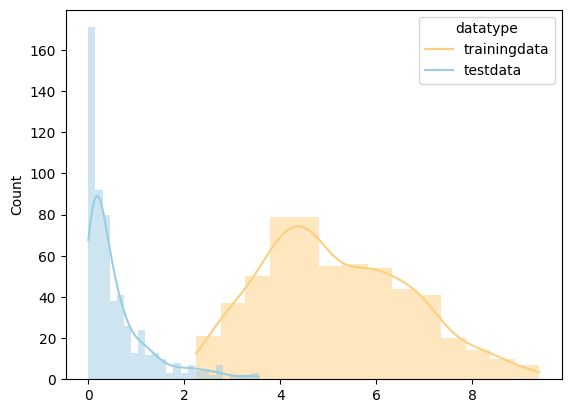

Using minmax scaler...


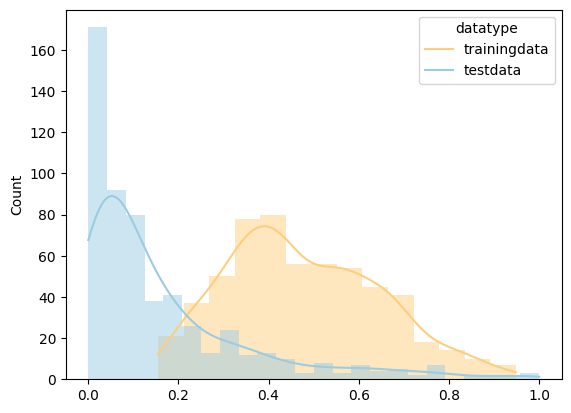

training data shape is  (5000, 567) 
test data shape is  (3000, 567)
Start training


 90%|████████▉ | 115/128 [01:07<00:04,  2.83it/s]

In [73]:
_, deconv_results = \
    Deconvolution(signature.T, pseudobulk_test_df,
                  sep='\t', scaler='mms',
                  datatype='counts', genelenfile=None,
                  mode='overall', adaptive=True, variance_threshold=0.98,
                  save_model_name=None,
                  batch_size=128, epochs=128, seed=1)

In [ ]:
deconv_results = ScadenDeconvolution(signature.T, pseudobulk_test_df, sep='\t',
                           batch_size=128, epochs=128)